## SNO+ Scattering Pseudo-MC
A simple test using known results to determine the viability of nuclear recoil
explaining the odd behaviour at 2.2 MeV.

In [4]:
# importing the usual suspects
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import numpy as np
from pathlib import Path
from multiprocessing import Pool, cpu_count
from math import floor
import copy
# enough of this tuple nonsense, let's use a C-like struct
from dataclasses import dataclass
from typing import Self


# random number generation
import random
# i just picked an arbitrary seed here
# if it matters it's easy to change
random.seed("snoplus")

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.formatter.useoffset'] = False

In [13]:
# now we read in the stopping power data from ASTAR
stoppingpowers = pd.read_csv(Path("stoppingpowers/lab.csv"))
# rename cols to make them easier to reference
stoppingpowers.columns = ["KE", "electron", "nuclear", "total"]
# reindex the dataframe by kinetic energy to make lookups easier
#stoppingpowers.set_index("KE", inplace=True)
print(stoppingpowers)

         KE  electron   nuclear   total
0    0.0180     0.691  0.068500  653.60
1    0.0200     0.730  0.063800  682.84
2    0.0225     0.774  0.058900  716.38
3    0.0250     0.816  0.054800  749.06
4    0.0275     0.856  0.051300  780.02
..      ...       ...       ...     ...
75  15.0000     0.430  0.000275  369.80
76  16.0000     0.408  0.000260  350.88
77  17.0000     0.389  0.000246  334.54
78  18.0000     0.371  0.000234  319.06
79  20.0000     0.341  0.000213  293.26

[80 rows x 4 columns]


So now we have the stopping power data available to us and formatted nicely.

The setup is that we have some sort of particle with a given energy E_0
The general process goes like this:
- Look up stopping power in the table for the energy of our event
- Find dE
- Add dE to the bin for an event of that energy
- Repeat this, as if we had an energy of E_j = E_0 - dE
- Terminate once E_j is less than some given epsilon (generally close to zero -
  but we will never reach zero exactly)

Implementation notes: Can use recursion, but that is setting myself up for a
nightmare so let's keep things iterative

Now we do the linear interpolation of the ASTAR data
Although the data is nonlinear, this is still decently accurate since it is a differentiable function 

In [14]:
# now to do the linear interpolation for the ASTAR dataset
def stp_interp(e, stp=stoppingpowers):
    # NOTE this assumes that the stopping powers are sorted
    # we get them this way from ASTAR so it's not an issue, but we can fix that if need be
    for k in stp.index:
        if e <= stp["KE"][k+1] and e >= stp["KE"][k]:
            return np.interp(e, list(stp["KE"]), list(stp["total"]))
        else:
            return ((list(stp["total"])[-1])/list(stp["KE"])[-1])*e



In [5]:
@dataclass
class AlphaEvent:
    alpha_path: list[float]
    proton_scatters: list[float]
    scatter_energy: list[float]


Here we define a function to compute the scattering probability for each event

*NB:* See http://hyperphysics.phy-astr.gsu.edu/hbase/Nuclear/crosec2.html#c1

In [6]:
def diff_cx(theta, ke, fname="diffcx_2p02MeV.csv") -> np.float64:
    exp_cx = pd.read_csv(fname)
    theta = np.rad2deg(theta)
    for k in exp_cx.index:
        if theta <= exp_cx['theta'][0]:
            # for low scattering angles which we don't have better data for 
            # (ie. below 12 degrees )
            # nvm 1/x makes a lot more sense here lol
            return 2*np.pi*((1/theta)) + 58.6308 
        elif theta <= exp_cx["theta"][k+1] and theta >= exp_cx['theta'][k]:
            return 2*np.pi*np.interp(theta, list(exp_cx['theta']), list(exp_cx['sigma']))
        elif theta >= list(exp_cx['theta'])[-1]:
            return 2*np.pi*((list(exp_cx['sigma'])[-1] - list(exp_cx['sigma'])[-2])/(list(exp_cx['theta'])[-1] - list(exp_cx['theta'])[-2]))*theta

def diffcx_riemann_sum(meshsize=0.01, fname='diffcx_2p02MeV.csv', theta_min=0.1, ke=8) -> np.float64:
    x_points = np.arange(theta_min, 1, meshsize)
    y_points = [diff_cx(i, ke) for i in x_points]
    return np.trapz(y_points, x_points, meshsize)


def scattering_probability(ke, dx, r_sum, density=0.8562, mol_wt=246.43) -> np.float64:
    sample_dim = 1
    sigma = r_sum*1E-24

    # now let's do the same stuff as before to determine the probability
    N_A = 6.02214E23 # mol^-1, avogadro's constant
    rho = density # g/cm^3, see above
    n = N_A/(mol_wt) * dx * rho

    eff_a = sigma*n
    total_a = sample_dim**2
    return eff_a/total_a
    
def scaled_diff_cx(theta, ke) -> np.float64:
    # luckily, our differential crossection s a decreasing function on the interval we care about
    # so, we just take the left endpoint as our x-value
    theta_min = 0.1
    scale = 1/(diff_cx(theta_min, ke))
    return diff_cx(theta,ke)*scale

def scattering_angle(ke) -> np.float64:
    theta_min = 0.1
    while True:
        # first we sample from a uniform distribution of valid x-values
        xsample = random.uniform(theta_min, 1)
        # then find the scaled differential crosssection at the x-sample
        scx = scaled_diff_cx(xsample, ke)
        # and then return the x-sample if a random number is less than that value
        if random.random() < scx:
            return xsample

Now let's sort out the transferred energy. In my notes I have the long
derivation for 2-d elastic collisions but that can be found in any classical
mechanics textbook.

Note that the initial velocity of the alpha particle is given since the initial
energy is known, and the scattering angle is sampled from the distribution given
by the differential crosssection.

Let
$$ \kappa = \frac{m_{\alpha}}{m_{p}} $$

Then, we have
$$
    v_{\alpha}^{\prime} = v_{\alpha}\frac{( \sqrt{1 - \kappa^2\sin^2{\theta_1}} )}{1 + \kappa}
$$

where $\theta_1$ is the scattering angle of the alpha, $\theta_2$ the angle of
the proton, primed velocities are final and unprimed are initial.

Now, using this and the intial equations we can find a relation describing
$\theta_2$. We have

$$
    \tan{\theta_2} = \frac{v_{\alpha}^{\prime}\sin{\theta_1}}{v_{\alpha} - v_{\alpha}^{\prime}\cos{\theta_1}}
$$

Finally, using these two we may find the final proton velocity

$$
v_{p}^{\prime} = \kappa v_{\alpha}\frac{\sin{\theta_1}}{\sin{\theta_2}}
$$

Yielding the final velocities of each particle.
After this, it's just a matter of substituting that velocity into the kinetic
energy expression using the appropriate mass.

And, we also have to re-write the energy transfer function since the
cross-section assumes things are in the CM frame.

I'm just going to take the solution from wikipedia here (and hope it works)
instead of doing the derivation myself this time. If I have to do it in the lab
frame then so be it, but I'd like to not.

In [7]:
def energy_transfer(e_i, scatter_angle=None):
    m_alpha = 6.646E-27 # kg
    m_proton = 1.6726E-27 # kg

    mev_to_j = 1.602176e-13
    ei_j = e_i * mev_to_j

    if scatter_angle is None:
        scatter_angle = scattering_angle(e_i)
    # just identifying scatter_angle as theta_1 to match the algebra
    # this is in the lab frame
    Theta = scatter_angle

    # and now we determine the final velocity of the alpha in the lab frame

    # first thing we need to do is to work out the velocity of the alpha
    # particle in the lab frame
    # note that the initial proton velocity in the lab frame is 0
    frac_energy = 2*m_alpha*m_proton*(np.cos(Theta) - 1)/((m_alpha + m_proton)**2)
    valpha_i = np.sqrt(2*ei_j/m_alpha)
    valpha_f = valpha_i * frac_energy
    vproton_f = (1-frac_energy)*valpha_i

    eproton_f = (1/mev_to_j)*0.5*m_proton*(vproton_f**2)
    ealpha_f = (1/mev_to_j)*0.5*m_alpha*(valpha_f**2)

    theta_1 = np.arctan(m_proton*np.sin(Theta)/(np.cos(Theta) -
    (m_alpha/m_proton)))

    return (ealpha_f, eproton_f, Theta)

    
    # and now to determine the velocity of the center of mass
    #v_cm = (m_alpha*valpha_i_lab)/(m_alpha + m_proton)


Now, let's write the function that does the simulation

In [8]:
def scatter_sim(e_0: float, alpha_path = list, stepsize=0.001, density=0.8562) -> AlphaEvent:
    # TODO add ability to get scattering angles out
    # we can do the binning/etc later

    # let's set both quenchin factors to 1 in here so we can tune them later
    a_path = copy.deepcopy(alpha_path)
    proton_event_path = []
    e_i = e_0
    # The alpha energy path is completely deterministic, so to speed things up
    # let's pre-bake it. Then, for each step we can do the scattering stuff

    # great, so now we have our pre-baked alpha energy
    # now we can iterate over the list and do the proton scattering
    scatter_e = []
    rsum = diffcx_riemann_sum(fname="diffcx_2p02MeV.csv")
    for s in range(len(a_path)):
        if scattering_probability(e_i, stepsize, rsum, density=density) > random.random():
            scatter_angle = scattering_angle(a_path[s])
            transfer_e = energy_transfer(a_path[s], scatter_angle=scatter_angle)
            a_path[s] = transfer_e[0]
            proton_event_path.append(transfer_e[1])
            scatter_e.append( (scatter_angle, transfer_e[1]) )

    #return (alpha_path, proton_event_path, scatter_e)
    return AlphaEvent(alpha_path, proton_event_path, scatter_e)

def gen_alpha_path(e_0, epsilon=0.1, stepsize=0.001) -> list[float]:
    e_i = e_0
    alpha_path = []
    while e_i > epsilon:
        alpha_path.append(e_i)
        e_i = e_i - stp_interp(e_i)*stepsize
    return alpha_path



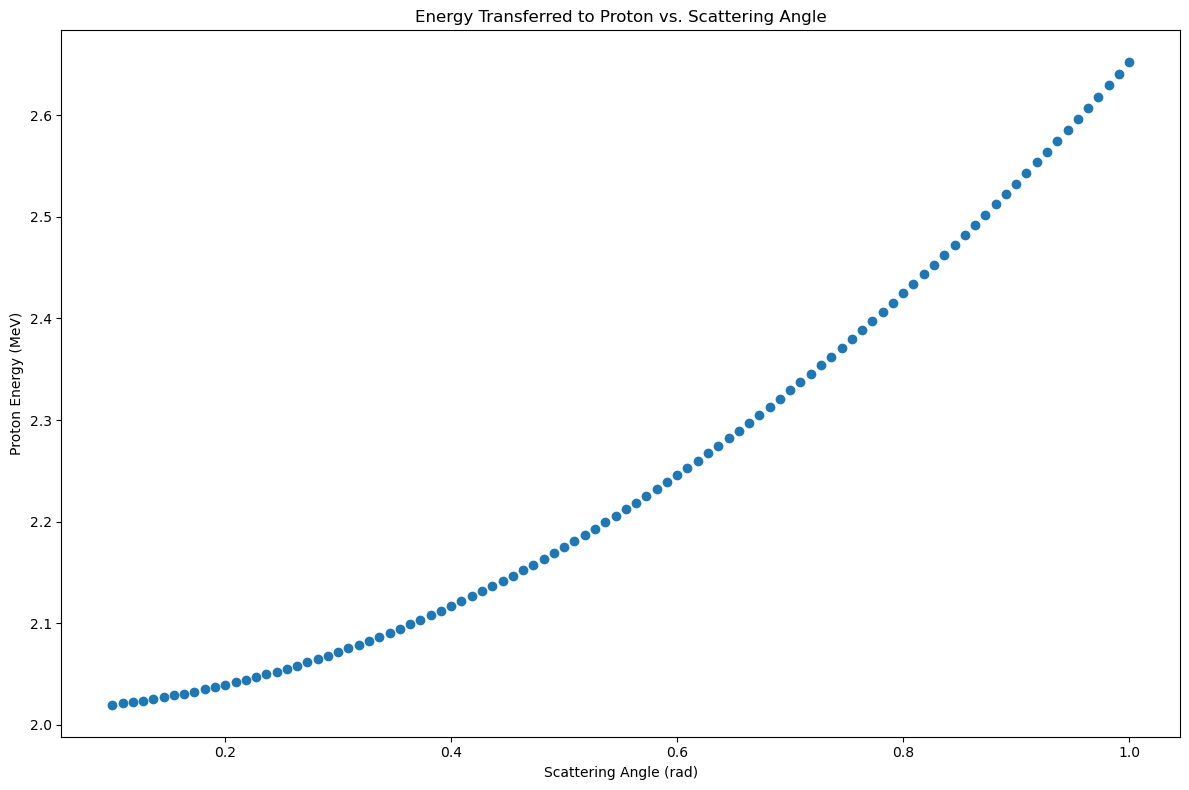

In [9]:
s_et_xrange = np.linspace(0.1, 1, 100)
t_e = [energy_transfer(8, i)[1] for i in s_et_xrange]
plt.scatter(s_et_xrange, t_e)
plt.xlabel("Scattering Angle (rad)")
plt.ylabel("Proton Energy (MeV)")
plt.title("Energy Transferred to Proton vs. Scattering Angle")
plt.tight_layout()
plt.savefig("etransfer_new.jpg")
plt.show()

In [11]:
s_angles = [scattering_angle(8) for i in range(1000)]
print(s_angles)
e_t_sa = [energy_transfer(8, s)[1] for s in s_angles]
#counts, bins = np.histogram(e_t_sa, bins=40)
#plt.hist(bins[:-1], bins, weights=counts, rwidth=0.8)
plt.scatter(s_angles, e_t_sa)
plt.xlabel("Angle")
plt.ylabel("Energy")
plt.tight_layout()

KeyboardInterrupt: 

In [16]:
# ok, now let's write a loop to process a lot of particles
# using one on each thread to speed things up
# considering this is a toy model, let's just use one thread for each particle
def run_sim_instance(e_0, alpha_path, stepsize=0.0001, nbins=80, epsilon=0.1, density=0.8562):
    run_data = scatter_sim(e_0, alpha_path, density=density, stepsize=stepsize)
    return run_data

def sim_wrapper(arg):
    args, kwargs = arg
    return run_sim_instance(*args, **kwargs)

def start_sim(e_0, n_particles, stepsize=0.001, nbins=40, epsilon=0.1, density=0.8562):
    alpha_path = gen_alpha_path(e_0, epsilon=epsilon, stepsize=stepsize)
    arg = (e_0, alpha_path)
    kwargs = {'stepsize': stepsize, 'nbins': nbins, 'epsilon': epsilon, 'density': density}
    with Pool(floor((2/3)*cpu_count())) as p:
        sim_data = p.map(sim_wrapper, [(arg, kwargs) for i in range(n_particles)])
        p.close()
        p.join()

    return sim_data

#sim_data = start_sim(8, 10000, nbins=50, stepsize=1E-6)
sim_data = start_sim(8, 100, nbins=50, stepsize=1E-6)


In [108]:
e_angles = []
for k in sim_data:
    e_angles.extend(k[2])

In [ ]:
print(e_angles)

[(0.2686145174546268, 0.05102440054547093), (0.1736710570191774, 0.5991357352725261), (0.21148529106426506, 0.1142009177070398), (0.10292532525881687, 0.07504434294585419), (0.16158678209106891, 0.027845639539125), (0.47526515890703025, 1.267046912221936), (0.14305575817157273, 0.2246569364679078), (0.9721324198116322, 0.06909000155424788), (0.25697660131836153, 0.09208647471001587), (0.867173902945992, 1.8350458319634493), (0.2557236492073798, 0.04330002335848497), (0.22793436020263663, 1.171922195112869), (0.14342988378647795, 0.04299922325405408), (0.6897289468156046, 1.3634876322650122), (0.28122805786471544, 0.08814452442826189), (0.8515981014524043, 0.7134575706836388), (0.11112629521764568, 0.04522232094593683), (0.2771745964317689, 0.028135698052797777), (0.17134318934890422, 0.046908186490693636), (0.2294760622767246, 1.0025478832085783), (0.24317848371480766, 0.034118103260816476), (0.23762069409945513, 0.6501917677241772), (0.3255824095404224, 0.21539586307012665), (0.186260

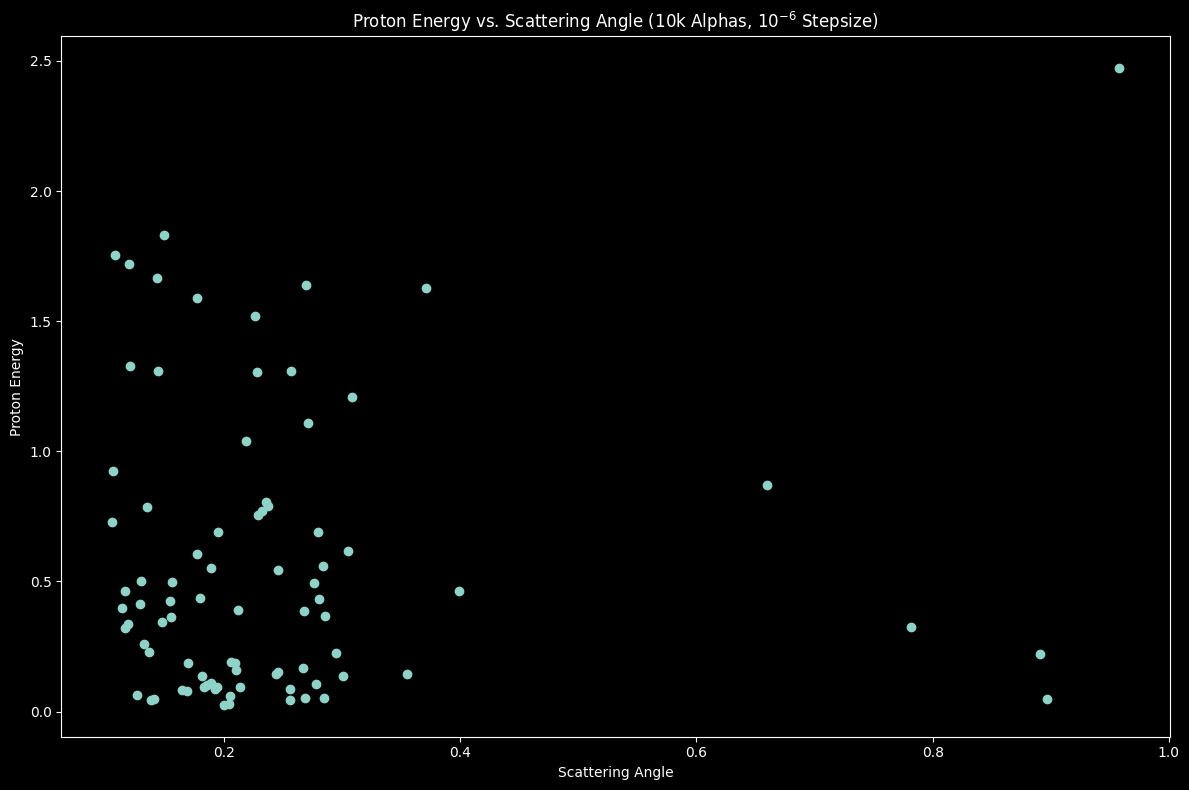

In [109]:
plt.style.use('dark_background')
plt.scatter(*zip(*e_angles))
plt.ylabel("Proton Energy")
plt.xlabel("Scattering Angle")
plt.title("Proton Energy vs. Scattering Angle (10k Alphas, $10^{-6}$ Stepsize)")
plt.tight_layout()
plt.show()
plt.style.use('default')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.formatter.useoffset'] = False

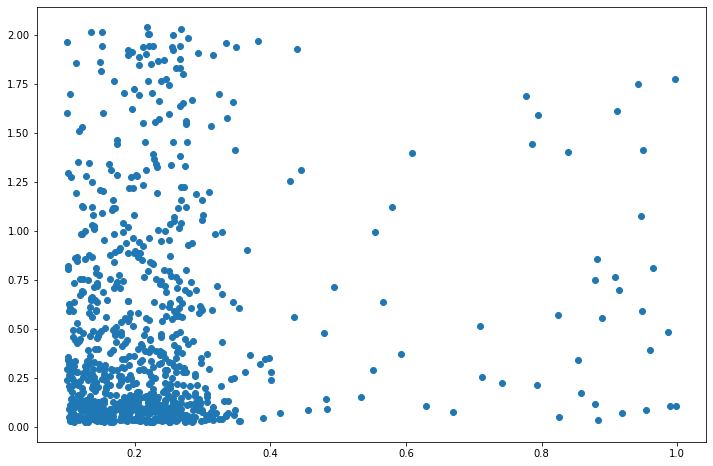

In [ ]:
protone = []
for x in sim_data:
    if x[2] != []:
        protone.append(x[2])

protone_ang = [x[0][0] for x in protone]
protone_e = [x[0][1] for x in protone]
plt.scatter(protone_ang, protone_e)

In [17]:
def quenched_spectrum(sim_data: AlphaEvent, proton_factor: float, alpha_factor: float=0.1) -> list:
    q_spec = []
    a_diffs = []
    a = 1
    while a < len(sim_data.alpha_path):
        a_diffs.append(abs(sim_data.alpha_path[a] - sim_data.alpha_path[a-1]))
        a += 1
    q_spec.append( sum( [alpha_factor*j for j in a_diffs] + [proton_factor*k for k in sim_data.proton_scatters] ) )
    return q_spec

def quenched_spectrum_wrapper(arg):
    args, kwargs = arg
    return quenched_spectrum(*args, **kwargs)

def quenched_spectrum_multithread(sim_data: list[AlphaEvent], proton_factor: float, alpha_factor: float=0.1) -> list[list]:
    arg = (proton_factor,)
    kwargs = {'alpha_factor': 0.1}
    with(Pool(floor((2/3)*cpu_count()))) as p:
        q_spec = p.map(quenched_spectrum_wrapper, [((i, *arg), kwargs) for i in sim_data])
        p.close()
        p.join()
    return q_spec

In [18]:
q_spec = quenched_spectrum_multithread(sim_data, 0.4)

In [19]:
q_spec = [l
          for ls in q_spec
          for l in ls
          ]

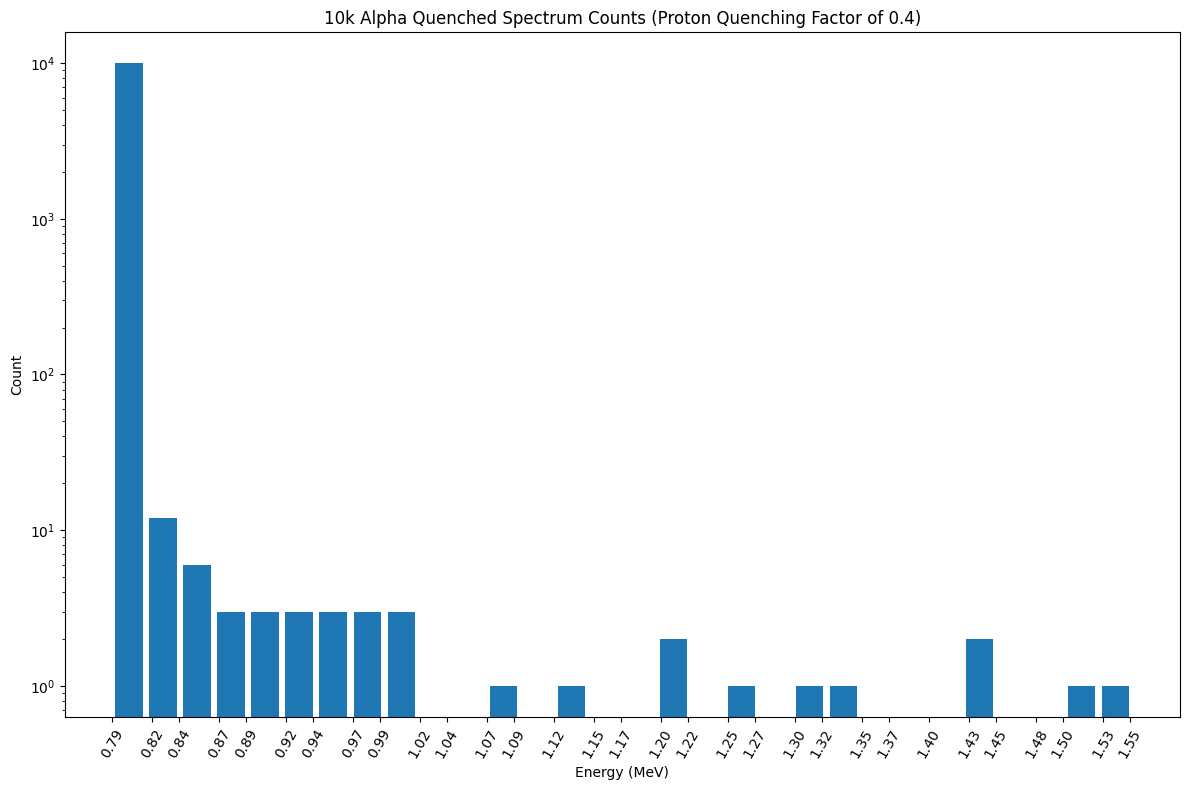

In [121]:
#quenched_spectrum_counts = BinnedCountData(25, startpoint=min(q_spec), endpoint=max(q_spec))
#quenched_spectrum_counts.add_count_by_list(q_spec)
#plt.hist(quenched_spectrum_counts.bin_edges[:-1],
#quenched_spectrum_counts.bin_edges, weights=quenched_spectrum_counts.counts,
#rwidth=0.8)

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.formatter.useoffset'] = False
counts, bins = np.histogram(q_spec, 30)
plt.hist(bins[:-1], bins, weights=counts, rwidth=0.8)
#plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.yscale('log')
plt.xticks([round(i, 2) for i in bins])
plt.xticks(rotation=60)
plt.ticklabel_format(style='plain', axis='x')
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
#plt.gca().xaxis.set_major_locator(tck.MultipleLocator(base=0.1))
plt.title("10k Alpha Quenched Spectrum Counts (Proton Quenching Factor of 0.4)")
plt.xlabel("Energy (MeV)")
plt.ylabel("Count")
plt.tight_layout()
#plt.savefig("q_spec_negsoln_5k_alphas_b_newcx_rev2_0p1toPi.jpg")
plt.show()

That spectrum looks pretty good! Now, let's do energy resolution smearing. The
dataset isn't too huge here so we're going to do it event by event.

Effectively how this works, is that we a parameter $N_{hit}$ determined at
runtime of the detector (the one we use is dependent on what data we want to
compare to). Then, for each event with energy $E$ we sample from the
distribution $N(E\cdot N_{hit},
\sqrt{E\cdot N_{hit}})$ (a normal with mean $E \cdot N_{hit}$ and standard
deviation $\sqrt{E \cdot N_{hit}}$) which gives us a smeared event in $N_{hit}$
space. Then, we just divide by $N_{hit}$ to transform back to energy space, and
we are done!

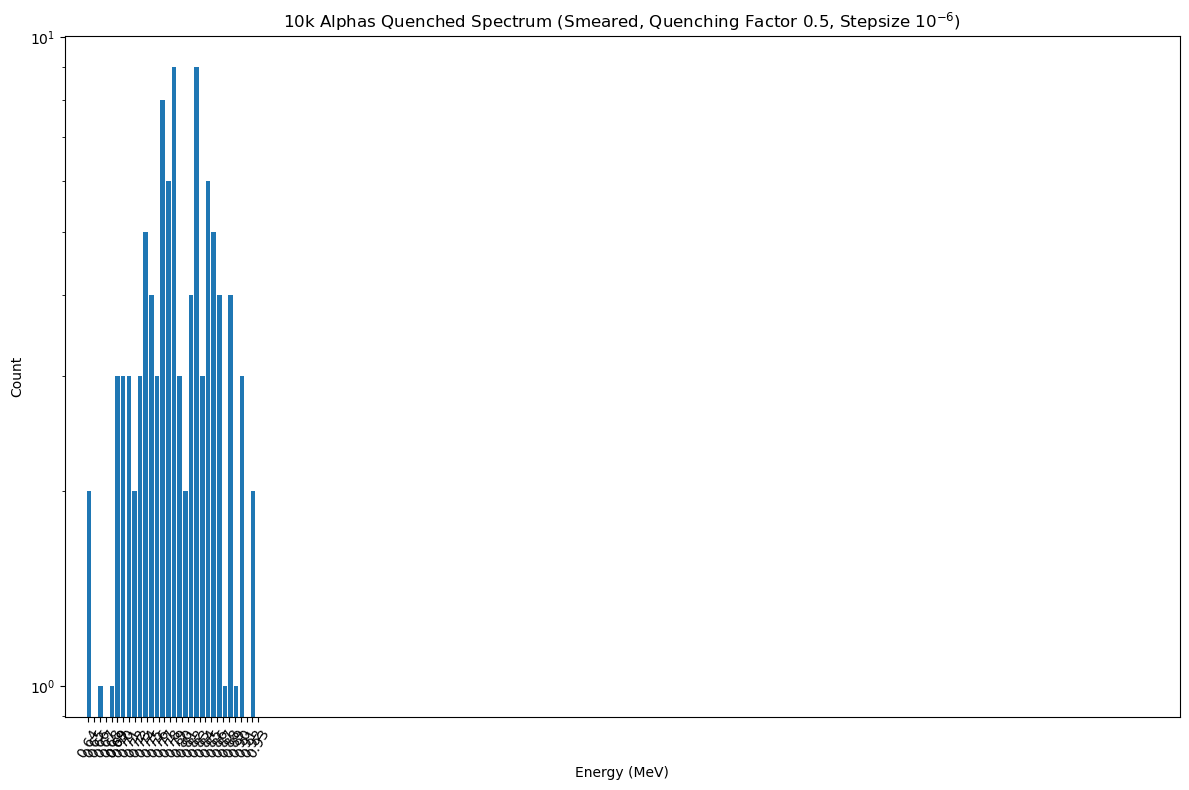

In [23]:
# this is a placeholder for right now

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.formatter.useoffset'] = False
nhit = 200 

q_spec_smeared = []

for i in range(len(q_spec)):
    e_i = q_spec[i]
    e_f = (random.gauss(e_i*nhit, np.sqrt(e_i*nhit)))/nhit
    q_spec_smeared.append(e_f)

counts, bins = np.histogram(q_spec_smeared, 30)
plt.hist(bins[:-1], bins, weights=counts, rwidth=0.8)
plt.yscale('log')
plt.xticks([round(i, 2) for i in bins])
plt.xticks(rotation=60)
plt.ticklabel_format(style='plain', axis='x')
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.title("10k Alphas Quenched Spectrum (Smeared, Quenching Factor 0.5, Stepsize $10^{-6}$)")
plt.xlabel("Energy (MeV)")
plt.ylabel("Count")
plt.xlim((0.6, 2.5))
plt.tight_layout()
plt.savefig("5k_quenched_smeared_0p4q_new2.jpg")
plt.show()